In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from geopy.distance import great_circle

import statsmodels.api as sm

from datetime import datetime

# The Data
I am currently using a dataset from Kaggle. The data is pre-split into 2 sets for training and testing. The training data I will be looking into in this EDA is approximately 200mb and consists of taxi trips in New York City for January 2016 to June 2016.

In [11]:
#loading data
taxi_df = pd.read_csv('data/train.csv')

Looking at the dimensions of the data, it consists of 11 columns and approximate 1.5 million rows

In [17]:
taxi_df.shape

(1458644, 11)

The Columns can be seen consist of:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

Since this data is from kaggle, it is relatively clean. However, it is a cleaned subset from the NYC Taxi and Limousine Commission (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This leaves the option if we need more accuracy for training our model, we can always download more data from the commission website and merge with our current dataset. However for our current EDA and limitation in processing power and memory, I will be focusing on this subset (which already consists of 1.5M rows). After running through our model and testing it, if scores/accuracy are low more data will be added.

In [18]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [109]:
taxi_df.isnull().values.any() #no missing values

False

Looking at the max and min values, there are obviously some huge outliers that may be incorrect data. This will be more evident when I start visualizing the data, most specifically in the trip_duration column.

In [19]:
taxi_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Because one of the goals of this project is to predict trip times, the trip_duration column will be our dependent variable in most cases. Since we are trying to solve a the vehicle routing problem, the passenger_count column may help give us more insight. However, with taxis and from this table, each pickup only has a single drop off. 

# Box Plots (Checking for Outliers)
Below are boxplots of the passenger count and trip_durration, the main take away from both these graphs are the existence of outliers. We have some outliers for the passenger count ranging up to 8 while a majority exists between 1 and 2, but simply looking at the trip_duration boxplot, we can see there are huge outliers. I will filter these out for future graphing purposes, however they cannot be ignored in the training of models as some do still hold information. But this evidence shows that the data is not completely as clean as I thought.

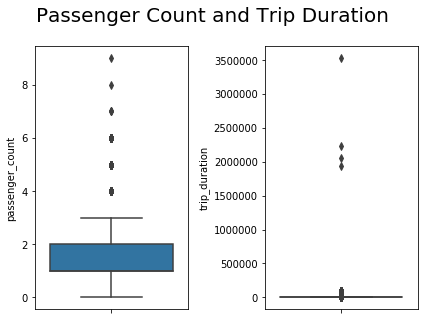

In [20]:
fig, ax = plt.subplots(1,2)

sns.boxplot(x=taxi_df["passenger_count"], orient='v', ax=ax[0])
sns.boxplot(x=taxi_df["trip_duration"], orient='v', ax=ax[1])

fig.suptitle('Passenger Count and Trip Duration', position=(.5,1.1), fontsize=20)

fig.tight_layout()

# Histograms and Density Plots

From the passenger number histogram, we can clearly see that a majority of taxi rides are one person rides with a steady decrease as the number of passengers increase.

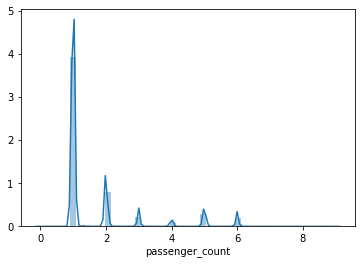

In [21]:
#passenger histogram
sns.distplot(taxi_df['passenger_count'])

From the density plot of trip duration we can clearly see the outliers mentioned before. There are major outliers existing at the 3500000 range which is approximately 900 hours.

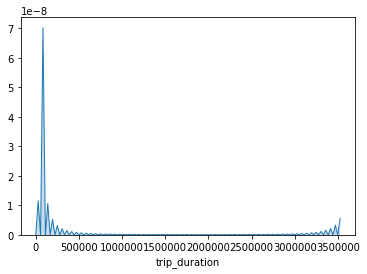

In [22]:
#trip duration density
sns.distplot(taxi_df['trip_duration'], hist=False, kde=True,
            kde_kws = {'shade': True, 'linewidth': 1})

Filtering the data set to where trip duration is less than 4000 seconds, we get a better look at how a majority of our data is distributed. We can see the trip_duration peaks around the 700 second mark which is a about 11 minutes. It is better to use a density plot that grouping the table (shown below) because eventhough trip duration are integers there is such a wide range, we cannot get a good grasp of how the spread looks.  

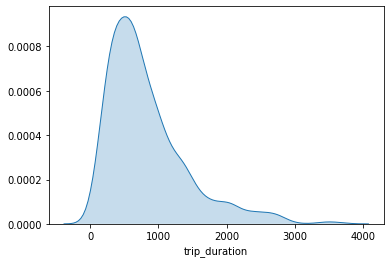

In [10]:
taxi_df['trip_duration'].describe()

sns.distplot(taxi_df.loc[taxi_df['trip_duration']<=4000]['trip_duration'], hist=False, kde=True,
            kde_kws = {'shade': True, 'linewidth': 1})

In [133]:
taxi_df.groupby('trip_duration').count()[['id']].reset_index().sort_values(by = 'id', ascending=False)

,trip_duration,id
367,368,1624
407,408,1584
347,348,1582
366,367,1581
357,358,1577
...,...,...
5987,8150,1
5986,8135,1
5985,8112,1
5984,8097,1


# Distance Analysis
I created my own function to find the distance using longitude and latitude inputs using this website: https://andrew.hedges.name/experiments/haversine/. The reason being, my version of geopy was causing errors with the data even though the data was correct. I did a cross comparison between my function and great_circle (seen below) and the results are relatively close so the distance should be accurate to a reasonable level. In addition, since I am using the same function across all rows, I am still able to compare the results with one another. The first step was creating a function to run through my longitudes and latitudes to get the distance. I then create a new column called trip_distance which holds the distance of each trip in miles. 

In [6]:
# #function to get distance and apply to taxi_df
# def get_distance(x1, y1, x2, y2):
    
#     pickup = (x1,y1)
#     dropoff = (x2,y2)
    
#     return(distance.distance(pickup,  dropoff).mi)

# approximate radius of earth in km
R = 6373.0

def get_distance(x1, y1, x2, y2):
    
    lat1 = math.radians(x1)
    lon1 = math.radians(y1)
    lat2 = math.radians(x2)
    lon2 = math.radians(y2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    
    return(distance)

Both functions produce approximately the same results. In addition, my function is faster so it's able to scale better for the large dataset.

In [9]:
great_circle((37.8, -122.4), (40.7, -74.0))

Distance(4127.316901887639)

In [10]:
get_distance(37.8, -122.4, 40.7, -74.0)

4128.606727086702

In [12]:
#create new column called trip_distance
taxi_df['trip_distance'] = taxi_df.apply(lambda x: get_distance(x.pickup_longitude, 
                                                                   x.pickup_latitude, 
                                                                   x.dropoff_longitude, 
                                                                   x.dropoff_latitude),
                     axis = 1) 

In [13]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.950590
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2.132847
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.360093
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.475668
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.328564


Once again I run a boxplot and we can see we have some major outliers. This is expected and most likely associated with the trips with extreme trip_durations. I will solve this for future graphs and ouputs by filtering the dataset beforehand so visualizations are more informative.

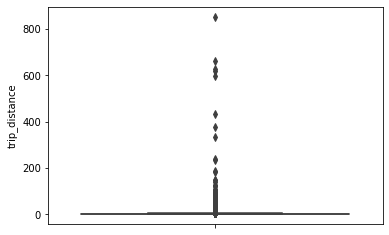

In [14]:
sns.boxplot(x=taxi_df["trip_distance"], orient='v')

Filtering out some of the longer trip durations and focusing on the left peaks we can see that the graphs look very similar. Once again this is expected as we expect a strong relationship between trip distance and duration.

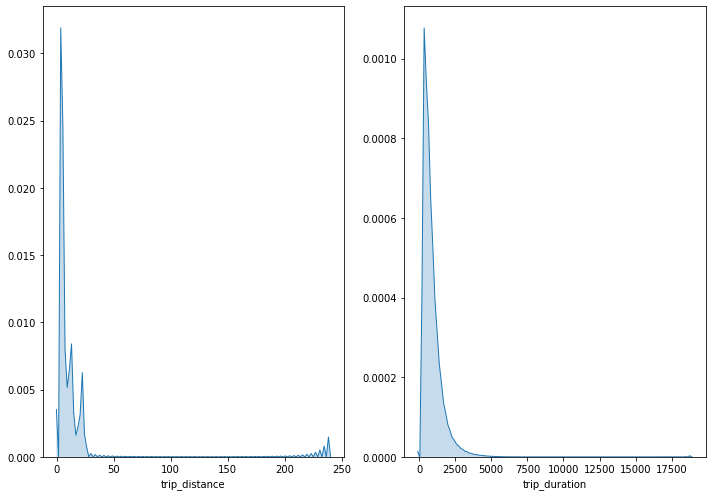

In [15]:
fig, ax = plt.subplots(1,2,figsize=(10,7))

sns.distplot(taxi_df.loc[taxi_df['trip_distance']<=300]['trip_distance'], hist=False, kde=True,
            kde_kws = {'shade': True, 'linewidth': 1},
            ax=ax[0])

sns.distplot(taxi_df.loc[taxi_df['trip_duration']<=20000]['trip_duration'], hist=False, kde=True,
            kde_kws = {'shade': True, 'linewidth': 1}, 
            ax=ax[1])

fig.tight_layout()

Looking at the scatterplot, the trip_duration outliers are altering our graphs.

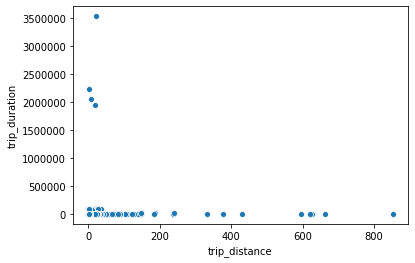

In [16]:
sns.scatterplot(x="trip_distance", y="trip_duration", data=taxi_df)

Removing the outliers and plotting the regression line, we can see a positive relationship between trip distance and trip duration. This is expected as longer distance trips should take a longer amount of time disregarding traffic. 

In [45]:
taxi_df.loc[taxi_df['trip_duration'] > 20000].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594,0.849036
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149,1.552968
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352,3.082212
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236,1.301433
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197,1.916108


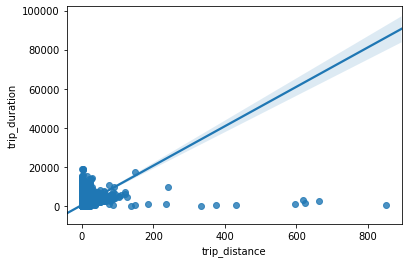

In [19]:
sns.regplot(x="trip_distance", y="trip_duration", data=taxi_df.loc[taxi_df['trip_duration'] < 20000])

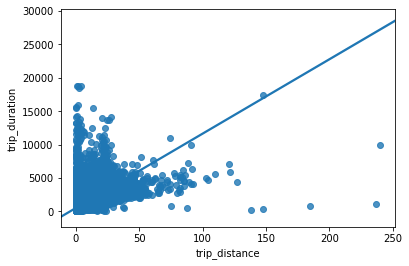

In [26]:
sns.regplot(x="trip_distance", y="trip_duration", data = taxi_df.loc[(taxi_df['trip_duration'] < 20000) & (taxi_df['trip_distance'] < 300)])

Delving deeper, I run a regression between the two and we can see the coefficient is statistically significant, however our R-squared and adjusted R-squared are only at about 8%.

In [19]:
x = taxi_df[['trip_distance']]
y = taxi_df['trip_duration']

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     89.92
Date:                Mon, 09 Mar 2020   Prob (F-statistic):           1.75e-20
Time:                        19:38:22   Log-Likelihood:                -9338.8
No. Observations:                1000   AIC:                         1.868e+04
Df Residuals:                     999   BIC:                         1.868e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
trip_distance   261.3758     27.564      9.482      0.000     207.285     315.467
==============================================================================
Omnibus:                     2673.004   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35126779.476
Skew:                          29.674   Prob(JB):                         0.00
Kurtosis:                     919.254   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Next I plot trip duration and distance, but in this model, I include passenger_count. I also run a multivariate regression once again and both coefficients are statistically significant. However, our R-squared and adjusted R-squared is only approx 10%.

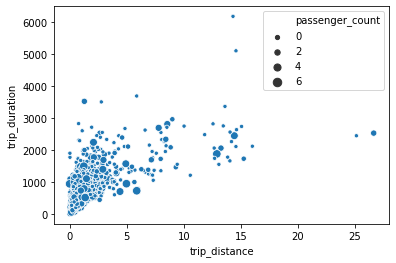

In [20]:
ax = sns.scatterplot(x="trip_distance", y="trip_duration", size="passenger_count",
                     data=taxi_df.loc[taxi_df['trip_duration'] < 20000])

In [21]:
x = taxi_df[['trip_distance', 'passenger_count']]
y = taxi_df['trip_duration']

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     59.76
Date:                Mon, 09 Mar 2020   Prob (F-statistic):           3.05e-25
Time:                        19:38:27   Log-Likelihood:                -9325.3
No. Observations:                1000   AIC:                         1.865e+04
Df Residuals:                     998   BIC:                         1.866e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
trip_distance     193.4299     30.162      6.413      0.000     134.242     252.618
passenger_count   236.5479     45.313      5.220      0.000     147.628     325.467
==============================================================================
Omnibus:                     2663.596   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34263700.261
Skew:                          29.409   Prob(JB):                         0.00
Kurtosis:                     907.914   Cond. No.                         1.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Finally, I run a correlation matrix/heatmap to see the realtionship between the various variables. As you can see once I filter out the outliers for the trip_duration, we see a spike in the correlation between duration and distance. Theres also a suprising correlation between pick up latitude and drop off latitude, which could mean that most people are going north.

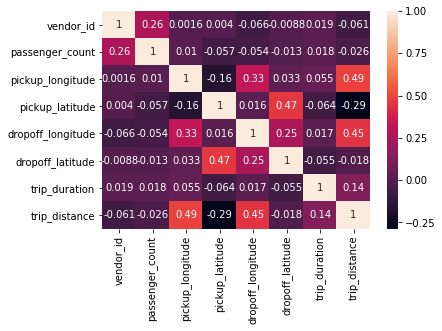

In [22]:
sns.heatmap(taxi_df.corr(), annot=True)

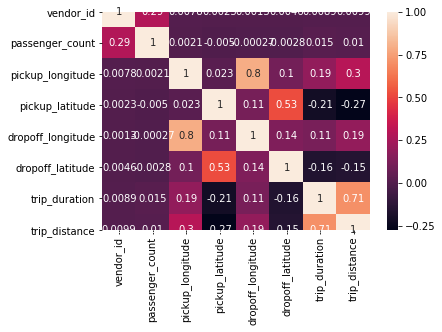

In [32]:
sns.heatmap(taxi_df.loc[(taxi_df['trip_duration'] < 20000) & (taxi_df['trip_distance'] < 300)].corr(), annot=True)

# Maps
I am using a shapefile of new york city from: https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27. By looking at the shapefile we want to keep drop-off and pickup points strictly in our visible map, thus I am going to limit the locations to between 40.4 and 41 latitude and -74.3 and -73.8 longitude. This is because I strictly want to predict the travel times within New York City because that's the training data we have. Having trips that go beyond the city would add noise to our data and weaken the training process.

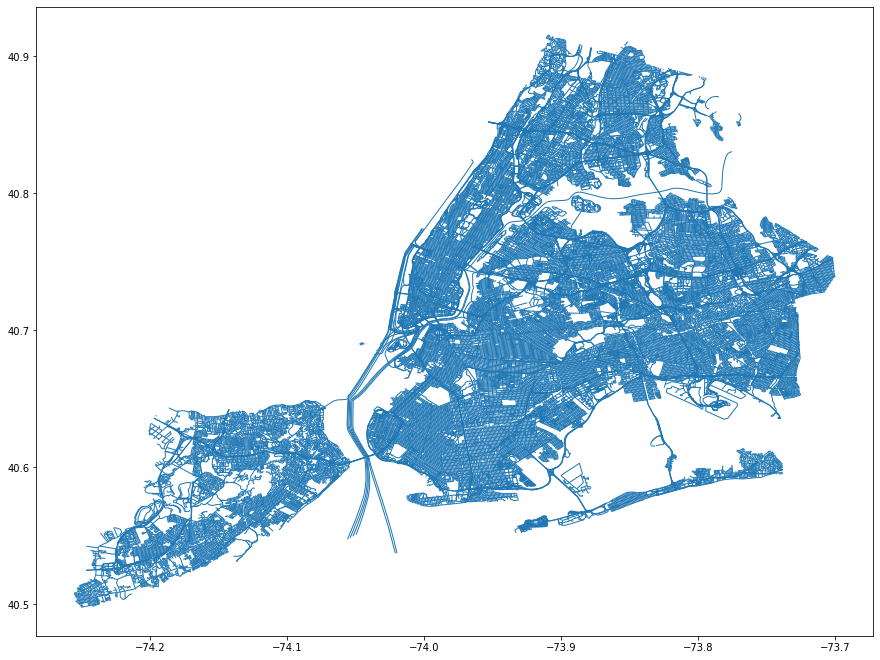

In [34]:
street_map = gpd.read_file('shp/geo_export_0a23a24b-8a75-4a43-b238-df5c9996dcf4.shp')

fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, linewidth=1)

In [36]:
#filtering to pick ups to just NYC
taxi_df = taxi_df.loc[taxi_df['pickup_longitude'].between(-74.3, -73.8, inclusive = True) & 
                      taxi_df['pickup_latitude'].between(40.4, 41, inclusive = True) & 
                      taxi_df['dropoff_longitude'].between(-74.3, -73.8, inclusive = True) & 
                      taxi_df['dropoff_latitude'].between(40.4, 41, inclusive = True)
                     ]

In [17]:
#converting coordinates to geometric points and creating geo dataframe
geometry_pickup = [Point(xy) for xy in zip(taxi_df['pickup_longitude'], taxi_df['pickup_latitude'])]

crs = {'init' : 'epsg:4326'}

geo_df = gpd.GeoDataFrame(taxi_df, crs = crs, geometry = geometry_pickup)

In [18]:
geo_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,POINT (-73.98215 40.76794)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,POINT (-73.98042 40.73856)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,POINT (-73.97903 40.76394)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,POINT (-74.01004 40.71997)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,POINT (-73.97305 40.79321)


Next I plot the heatmap/density maps of pickup and dropoff locations. We can see that both that most pickup and dropoffs are within the main city. However, the dropoff locations are significantly more widespread than pickup locations. We can deduce that most people are moving from the inner city to outer portions, however it is still highly concentrated both in pickup and dropoff in central areas.

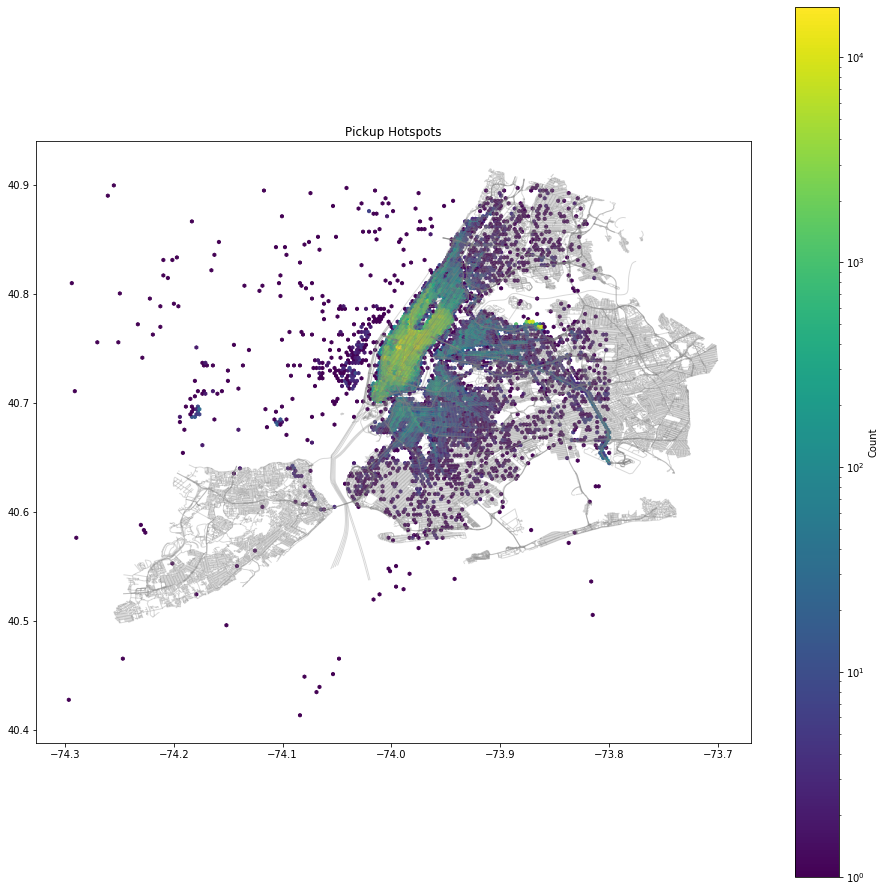

In [37]:
fig, ax = plt.subplots(figsize=(16,16))

#Plotting city streets
street_map.plot(ax = ax, alpha = 0.3, color = 'grey', linewidth=1)

#Plot hexbins
hb = plt.hexbin(taxi_df.pickup_longitude, taxi_df.pickup_latitude, bins='log', mincnt=1, gridsize=180)

#Adding key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')

# Title and bounds
ax.set_title('Pickup Hotspots')

plt.show()

In [56]:
geometry_dropoff = [Point(xy) for xy in zip(taxi_df['dropoff_longitude'], taxi_df['dropoff_latitude'])]

crs = {'init' : 'epsg:4326'}

geo_df_dropoff = gpd.GeoDataFrame(taxi_df, crs = crs, geometry = geometry_dropoff)

geo_df_dropoff.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance,geometry
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.950590,POINT (-73.96463 40.76560)
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2.132847,POINT (-73.99948 40.73115)
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.360093,POINT (-74.00533 40.71009)
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.475668,POINT (-74.01227 40.70672)
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.328564,POINT (-73.97292 40.78252)


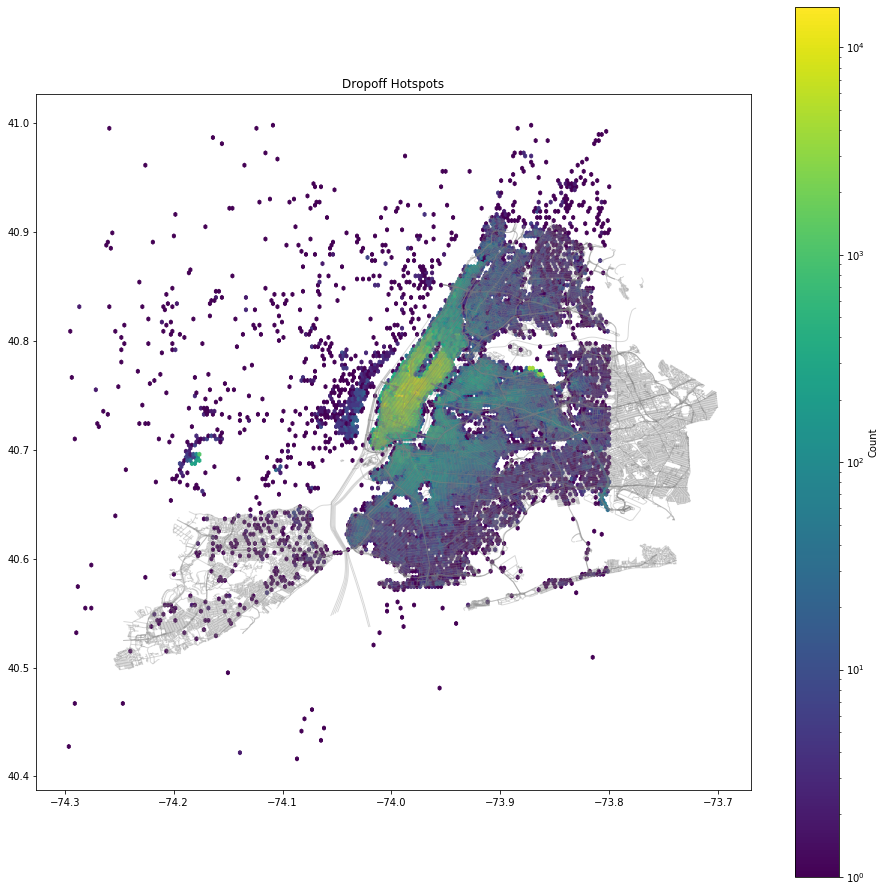

In [38]:
fig, ax = plt.subplots(figsize=(16,16))

#Plotting city streets
street_map.plot(ax = ax, alpha = 0.3, color = 'grey', linewidth = 1)

#Plot hexbins
hb = plt.hexbin(taxi_df.dropoff_longitude, taxi_df.dropoff_latitude, bins='log', mincnt=1, gridsize=180)

#Adding key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')

ax.set_title('Dropoff Hotspots')

plt.show()

# Time Series Relationships
Finally, I am seeing if there are any relationships with time and trip duration. This will help eliminate the traffic factor of our problem. By adding the input of time into our training model, we will hopefully be able to more accurately predict trip durations. This also helps eliminate other confounding factors which can alter trip times such as seasonal weather.

I expect a cyclical pattern if I do decide to merge the data beyond the current training set to improve the training model. This will allow to extend these findings across all years of data assuming there will be no huge impacts e.g. world distasters, financial crises, etc.

In [61]:
#changing datetime column to datetime class
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'])

In [105]:
taxi_df['pickup_datetime'].describe()

count                 1458644
unique                1380222
top       2016-03-04 08:07:34
freq                        5
first     2016-01-01 00:00:17
last      2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

In [62]:
#adding hour column
taxi_df['pickup_hour'] = taxi_df.apply(lambda x: x.pickup_datetime.hour, axis = 1) 

#adding month column
taxi_df['pickup_month'] = taxi_df.apply(lambda x: x.pickup_datetime.month, axis = 1) 

#adding day of month column
taxi_df['pickup_day'] = taxi_df.apply(lambda x: x.pickup_datetime.day, axis = 1) 

#adding day of week column
taxi_df['pickup_weekday'] = taxi_df.apply(lambda x: datetime.weekday(x.pickup_datetime), axis = 1) 

In [63]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance,geometry,pickup_hour,pickup_month,pickup_day,pickup_weekday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.950590,POINT (-73.96463 40.76560),17,3,14,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2.132847,POINT (-73.99948 40.73115),0,6,12,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.360093,POINT (-74.00533 40.71009),11,1,19,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.475668,POINT (-74.01227 40.70672),19,4,6,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.328564,POINT (-73.97292 40.78252),13,3,26,5


Looking at the 4 line graphs below we can see that trip durations peak at certain times. We see a shart increase after 6:00am which can be related to people going to work and the highest peak at the 15th hour (3:00pm) when people are going home from work and a steady decrease from there.

From the month graph we can see an increase from January to June, a possible reasoning could be summer months have more tourists, thus more taxi rides and traffic.

The day of the month does not tell us much information, but it is interesting to see that the longest rides are during the 25th or towards the end of each month.

Finally, we see trip durations peak during the day 3 of the week (which is Thursday as Monday is set to 0) and drop as we reach the weekend. 

C:\Users\eldon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


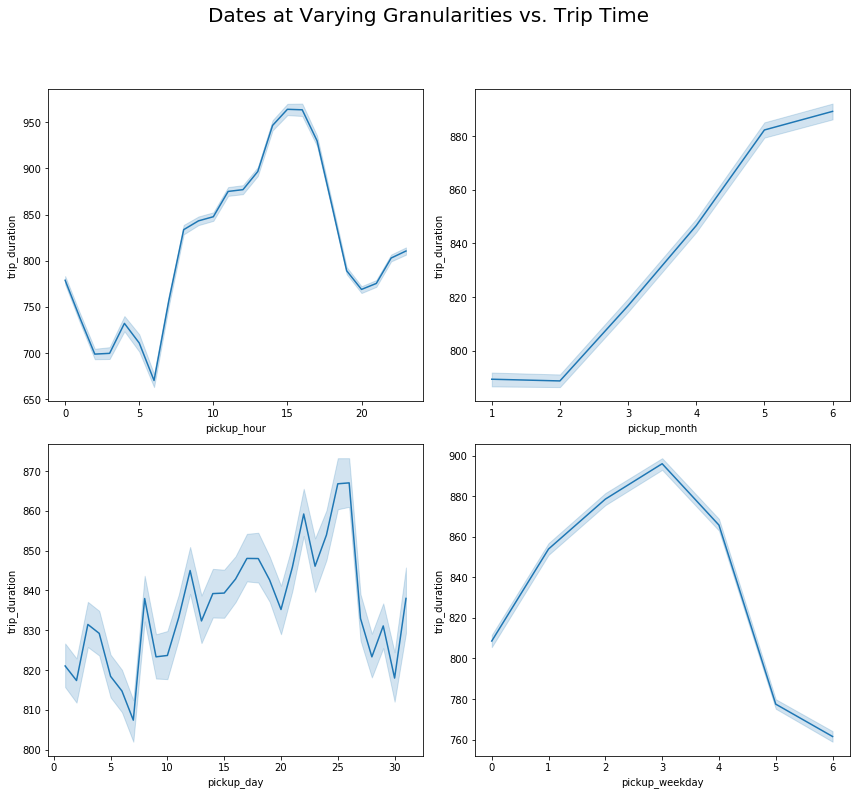

In [64]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
jitter = [[False, 1], [0.5, 0.2]]

ax[0][0] = sns.lineplot(x="pickup_hour", y="trip_duration", data=taxi_df.loc[taxi_df['trip_duration'] < 20000], ax=ax[0][0])

ax[1][0] = sns.lineplot(x="pickup_day", y="trip_duration", data=taxi_df.loc[taxi_df['trip_duration'] < 20000], ax=ax[1][0])

ax[0][1] = sns.lineplot(x="pickup_month", y="trip_duration", data=taxi_df.loc[taxi_df['trip_duration'] < 20000], ax=ax[0][1])

ax[1][1] = sns.lineplot(x="pickup_weekday", y="trip_duration", data=taxi_df.loc[taxi_df['trip_duration'] < 20000], ax=ax[1][1])

fig.suptitle('Dates at Varying Granularities vs. Trip Time', position=(.5,1.1), fontsize=20)
fig.tight_layout()
fig.show()